In [1]:
#Building / continuing from SL_library_dataloading, we consider BT from here: https://keremturgutlu.github.io/self_supervised/14%20-%20barlow_twins.html
#and here https://keremturgutlu.github.io/self_supervised/14%20-%20barlow_twins.html#BarlowTwinsModel

In [1]:
import fastai
fastai.__version__

'2.6.3'

In [2]:
import torch
torch.__version__

/Users/hamishhaggerty/opt/anaconda3/envs/old_fastai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.11.0'

In [3]:
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
import inspect

#These are imports

In [4]:
Module #So some fastai thing

fastai.torch_core.Module

In [5]:
#Like most other SSL algorithms BT's model consists of an encoder and projector (MLP) layer.
#Definition is straightforward:
#https://colab.research.google.com/github/KeremTurgutlu/self_supervised/blob/master/nbs/14%20-%20barlow_twins.ipynb#scrollTo=1M6QcUChcvpz

class BarlowTwinsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,projector):self.encoder,self.projector = encoder,projector
        
    def forward(self,x): return self.projector(self.encoder(x))
    
    
#Nothing much to this: Just a simple API for the BT model, with inputs encoder and projector. 


In [6]:
#HOWEVER instead of directly using the above, by passing both an encoder and a projector, create_barlow_twins_model
#function can be used by minimally passing a predefined encoder and the expected input channels.

#In the paper it's mentioned that MLP layer consists of 3 layers... following function will create a 3 layer
#MLP projector with batchnorm and ReLU by default. Alternatively, you can change bn and nlayers. 


#Questions: Why torch.no_grad() when doing this?
def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    return BarlowTwinsModel(encoder, projector)

#Similar to above. Simple API to make the BT model:

In [7]:
#You can use self_supervised.layers module to create an encoder. 

encoder = create_encoder("tf_efficientnet_b0_ns",n_in=3,pretrained=False,pool_type=PoolingType.CatAvgMax)
model = create_barlow_twins_model(encoder,hidden_size=2048,projection_size=128,nlayers=2)
out = model(torch.randn((2,3,224,224))); out.shape

torch.Size([2, 128])

In [8]:
get_multi_aug_pipelines

<function self_supervised.augmentations.get_multi_aug_pipelines(n, size, rotate=True, jitter=True, bw=True, blur=True, resize_scale=(0.2, 1.0), resize_ratio=(0.75, 1.3333333333333333), rotate_deg=30, jitter_s=0.6, blur_s=(4, 32), same_on_batch=False, flip_p=0.5, rotate_p=0.3, jitter_p=0.3, bw_p=0.3, blur_p=0.3, stats=([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), cuda=False, xtra_tfms=[])>

In [9]:
#BarlowTwins Callback
#The following parameters can be passed:
# - aug_pipelines
# Imb lambda is the weight for redundancy reduction term in the loss function

@delegates(get_multi_aug_pipelines)
def get_barlow_twins_aug_pipelines(size,**kwargs): return get_multi_aug_pipelines(n=2,size=size,**kwargs)

In [10]:
aug_pipelines = get_barlow_twins_aug_pipelines(size=28,rotate=False,jitter=False,bw=False,blur=False,stats=None,cuda=False)
aug_pipelines

print(inspect.signature(get_barlow_twins_aug_pipelines)) #If we comment out @delegates above, then only size is printed
                                                         #here; i.e. just prints **kwargs instead of all the actual 
                                                         #keyword arguments!


(size, rotate=True, jitter=True, bw=True, blur=True, resize_scale=(0.2, 1.0), resize_ratio=(0.75, 1.3333333333333333), rotate_deg=30, jitter_s=0.6, blur_s=(4, 32), same_on_batch=False, flip_p=0.5, rotate_p=0.3, jitter_p=0.3, bw_p=0.3, blur_p=0.3, stats=([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), cuda=False, xtra_tfms=[])


In [11]:
#export
class BarlowTwins(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines, lmb=5e-3, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)
                    
            
    def before_batch(self):
        xi,xj = self.aug1(self.x), self.aug2(self.x)
        self.learn.xb = (torch.cat([xi, xj]),)
        
    
    #loss function for BT. This is where the action is at: and potentially where I can make my edits...
    def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
        bs,nf = pred.size(0)//2,pred.size(1)

        z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2

        z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
        z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
        C = (z1norm.T @ z2norm) / bs 
        cdiff = (C - self.I)**2
        loss = (cdiff*self.I + cdiff*(1-self.I)*self.lmb).sum() 
        return loss

    
    @torch.no_grad()
    def show(self, n=1):
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:] 
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

In [12]:
bs=64
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=GrandparentSplitter()(items))
dls = tds.dataloaders(bs=bs, after_item=[ToTensor(), IntToFloatTensor()], device='cpu')

In [13]:
len(dls.train_ds)

709

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


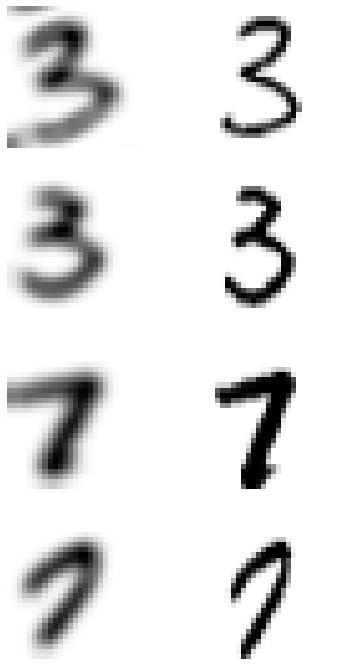

In [91]:
#Let's build a reasonable composite augmentation: initially copy pasted from aug_pipe_exploration

fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_barlow_twins_model(fastai_encoder, hidden_size=1024,projection_size=10)# projection_size=1024)
#So aside from size, randomresizedcrop takes in two args: resize_scale and resize_ratio. So we want to put in 
#values for these which is tantamount to doing nothing

#So if we choose resize_scale=(1,1) then the images look the same.
#IMPORTANT: So this aug pipelines, insofar as I can tell at the moment, is tantamount to "do nothing"
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=False)

learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines, print_augs=True)])
b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=4)

In [19]:
#learn.recorder.losses

So, in the above we train Barlow Twins on `MNIST_TINY`. 

Next step: Figure out what exactly we are training on. Then we want to "fine tune" on validation set and examine 
performance. 

Ok, for now let's just train as usual. We WILL improve this later. Iterate...

In [16]:
import torch
from torch import nn

In [63]:
#Now, train a classifier on the embedding!

class LinearClassifier(nn.Module):
    
    def __init__(self,zdim):
        super().__init__()
        self.fc1 = nn.Linear(zdim,2) #As only 2 classes in TINY_MNIST
        
    def forward(self,x):
        x = cast(self.fc1(x),Tensor) #so we have to use cross entropy loss. cast is because using old version fastai 
        return x

In [81]:
bs=128
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=GrandparentSplitter()(items))
dls = tds.dataloaders(bs=bs,num_workers=0, after_item=[ToTensor(), IntToFloatTensor()], device='cpu')

# print(len(list(iter(dls.valid))))
# print(len(list(iter(dls.train))))

dls.__getitem__

<bound method DataLoaders.__getitem__ of <fastai.data.core.DataLoaders object at 0x7fea38bb1270>>

In [82]:
inspect.signature(Datasets)

<Signature (items=None, tfms=None, tls=None, n_inp=None, dl_type=None, use_list=None, do_setup=True, split_idx=None, train_setup=True, splits=None, types=None, verbose=False)>

In [106]:
fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_barlow_twins_model(fastai_encoder, hidden_size=100,projection_size=10)# projection_size=1024)

#Use aug pipeline from above
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=False)
learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines, print_augs=True)])#,ShortEpochCallback(0.001)])



Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


In [84]:
dls.valid.bs = len(list(iter(dls.valid_ds))) #Set the validation dataloader batch size to be the length of the validation dataset

In [102]:
learn.fit(10)
print('done')

epoch,train_loss,valid_loss,time
0,4.481211,0.523312,00:31
1,2.550570,0.344377,00:29
2,1.722758,0.450311,00:25
3,1.305827,1.672014,00:24
4,1.084992,1.321896,00:33
5,0.908646,2.553658,00:38
6,0.778418,0.228959,00:29
7,0.681825,0.484004,00:45
8,0.611699,0.244738,00:33
9,0.552262,0.230420,00:30


done


In [107]:
#Train Classifier on encoder(tiny_mnist)

zdim=1024 #see above
head = LinearClassifier(zdim=zdim)
optimizer = torch.optim.Adam(head.parameters())
criterion = nn.CrossEntropyLoss()
EPOCHS=100
for epoch in range(EPOCHS):
    #break 
    b = dls.train.one_batch() #Seems need dls[0] or dls.train for training ... dls[1] is validation see here https://docs.fast.ai/data.core.html#DataLoaders.__getitem__
    x,y = b[0],b[1]

    loss = criterion(head(fastai_encoder(x)),y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch>90:
        print(loss)
        

TensorCategory(0.0854, grad_fn=<AliasBackward0>)
TensorCategory(0.0670, grad_fn=<AliasBackward0>)
TensorCategory(0.0690, grad_fn=<AliasBackward0>)
TensorCategory(0.1045, grad_fn=<AliasBackward0>)
TensorCategory(0.0913, grad_fn=<AliasBackward0>)
TensorCategory(0.0987, grad_fn=<AliasBackward0>)
TensorCategory(0.0759, grad_fn=<AliasBackward0>)
TensorCategory(0.0940, grad_fn=<AliasBackward0>)
TensorCategory(0.1206, grad_fn=<AliasBackward0>)


In [108]:
#Test result of above cell on the validation set - assumes that batch size of valid-dataloader is = number of valid samples                                        
b = dls.valid.one_batch()
x,y = b[0],b[1]
ypred = head(fastai_encoder(x))
correct = (torch.argmax(ypred,dim=1) == y).type(torch.FloatTensor)
print(correct.mean().item())



0.9756795167922974


In [98]:
#Just train a linear classifier (no encoder)
#Basically cell above but remove encoder and some re-shaping

zdim=28*28 #see above
head = LinearClassifier(zdim=zdim)
optimizer = torch.optim.Adam(head.parameters())
criterion = nn.CrossEntropyLoss()

EPOCHS=100
for epoch in range(EPOCHS):
    #break
    b = dls.train.one_batch() #see here https://docs.fast.ai/data.core.html#DataLoaders.__getitem__
    x,y = b[0],b[1]

    x=x.view(bs,zdim)
    x=cast(x, Tensor) #Have to do this when using old version of fastai for some reason...

    out = head(x)
    loss = criterion(out,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch>90:
        print(loss)


TensorCategory(0.0934, grad_fn=<AliasBackward0>)
TensorCategory(0.1077, grad_fn=<AliasBackward0>)
TensorCategory(0.1053, grad_fn=<AliasBackward0>)
TensorCategory(0.1171, grad_fn=<AliasBackward0>)
TensorCategory(0.0996, grad_fn=<AliasBackward0>)
TensorCategory(0.1304, grad_fn=<AliasBackward0>)
TensorCategory(0.1345, grad_fn=<AliasBackward0>)
TensorCategory(0.1613, grad_fn=<AliasBackward0>)
TensorCategory(0.1340, grad_fn=<AliasBackward0>)


In [100]:
#Test result of above cell, (i.e. just a linear classifier), on the validation set - assumes that batch size of valid-dataloader is = number of valid samples                                        
b = dls.valid.one_batch()
x,y = b[0],b[1]
x = x.view(-1,zdim)
ypred = head(x)

correct = (torch.argmax(ypred,dim=1) == y).type(torch.FloatTensor)
print(correct.mean().item())

0.9842632412910461
